### Import Packages - All Required Packages and Modules for Pipeline

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from xgboost import XGBRegressor

### Data Setup - Bring in Train and Test Datasets, Identify & Store Target Variable, Write Set Identifiers, Combine Sets

In [2]:
train = pd.read_csv("Data/train.csv")
test = pd.read_csv("Data/test.csv")

In [3]:
[i for i in train.columns if i not in test.columns]

['SalePrice']

In [4]:
y_train = train["SalePrice"]

In [5]:
train = train.drop("SalePrice", axis=1)

In [6]:
train["SetIdentifier"] = "Train"
test["SetIdentifier"] = "Test"

In [7]:
df = pd.concat([train, test]).reset_index(drop=True)

In [8]:
pd.set_option('display.max_rows', len(df.columns))

### Target Variable Selection - Chart Normal and Logged Target Variable Distribution

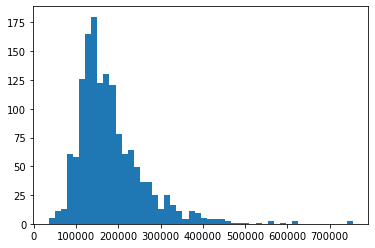

In [9]:
plt.hist(y_train, bins=50)
plt.show()

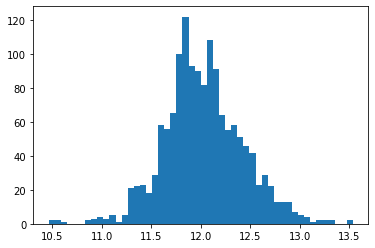

In [10]:
plt.hist(np.log(y_train), bins=50)
plt.show()

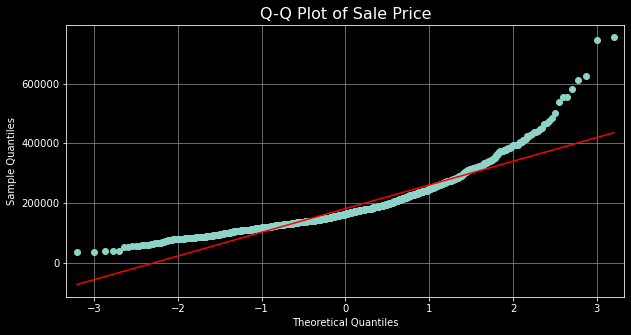

In [11]:
plt.style.use('dark_background')
data = y_train
data_series = pd.Series(data, name="Sale Price")
fig, ax = plt.subplots(figsize=(10, 5))
sm.qqplot(data_series, line='s', ax=ax)
ax.set_title("Q-Q Plot of Sale Price", color='white', fontsize=16)
ax.set_xlabel("Theoretical Quantiles", color='white')
ax.set_ylabel("Sample Quantiles", color='white')
ax.tick_params(colors='white')
ax.grid(color='gray')
plt.show()

*Logged Target Variable is Much Better Normally Distributed, will be Moddelled as Logged*

### Null Handling - Split into Column Type and Address on an Ad-Hoc Basis

In [12]:
df.isna().sum()[df.isna().sum() > 0]

MSZoning           4
LotFrontage      486
Alley           2721
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        24
MasVnrArea        23
BsmtQual          81
BsmtCond          82
BsmtExposure      82
BsmtFinType1      79
BsmtFinSF1         1
BsmtFinType2      80
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
Electrical         1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
FireplaceQu     1420
GarageType       157
GarageYrBlt      159
GarageFinish     159
GarageCars         1
GarageArea         1
GarageQual       159
GarageCond       159
PoolQC          2909
Fence           2348
MiscFeature     2814
SaleType           1
dtype: int64

In [13]:
df.dtypes[df.isna().sum() > 0]

MSZoning         object
LotFrontage     float64
Alley            object
Utilities        object
Exterior1st      object
Exterior2nd      object
MasVnrType       object
MasVnrArea      float64
BsmtQual         object
BsmtCond         object
BsmtExposure     object
BsmtFinType1     object
BsmtFinSF1      float64
BsmtFinType2     object
BsmtFinSF2      float64
BsmtUnfSF       float64
TotalBsmtSF     float64
Electrical       object
BsmtFullBath    float64
BsmtHalfBath    float64
KitchenQual      object
Functional       object
FireplaceQu      object
GarageType       object
GarageYrBlt     float64
GarageFinish     object
GarageCars      float64
GarageArea      float64
GarageQual       object
GarageCond       object
PoolQC           object
Fence            object
MiscFeature      object
SaleType         object
dtype: object

In [14]:
basement_nulls = ["BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2"]
garage_nulls = ["GarageType", "GarageQual", "GarageFinish", "GarageCond"]

In [15]:
for i in [basement_nulls, garage_nulls]:
    for j in i:
        df[j] = df[j].fillna("None")

In [16]:
mode_targs = ["MSZoning", "Exterior1st", "Exterior2nd", "Electrical", "Functional"
              , "KitchenQual", "SaleType"]
none_targs = ["Alley", "MasVnrType", "FireplaceQu", "PoolQC", "Fence", "MiscFeature"]
zero_targs = ["LotFrontage", "MasVnrArea", "BsmtFinSF1", "BsmtFinSF2"
              , "BsmtUnfSF", "TotalBsmtSF", "BsmtFullBath", "BsmtHalfBath"
              , "GarageCars", "GarageArea"
             ]
drop_targs = ["Utilities"]

In [17]:
for i in mode_targs:
    df[i] = df[i].fillna(df[i].mode()[0])

In [18]:
for i in none_targs:
    df[i] = df[i].fillna("None")

In [19]:
for i in zero_targs:
    df[i] = df[i].fillna(0)

In [20]:
for i in drop_targs:
    df = df.drop(i, axis=1)

### Explore Dataset - Data Types, Summary Statistics, Charts, Correlation Matrix and Investigation

In [78]:
df["RoofStyle"].dtypes

dtype('O')

In [22]:
types = ["object", "int64", "float64"]

cols_type = {}

for j in types:
    cols_type[j] = [i for i in df.columns if df[i].dtype == j]

In [23]:
df[cols_type['int64']].describe().transpose().drop('Id')

,count,mean,std,min,25%,50%,75%,max
MSSubClass,2919.0,57.137718,42.517628,20.0,20.0,50.0,70.0,190.0
LotArea,2919.0,10168.114080,7886.996359,1300.0,7478.0,9453.0,11570.0,215245.0
OverallQual,2919.0,6.089072,1.409947,1.0,5.0,6.0,7.0,10.0
OverallCond,2919.0,5.564577,1.113131,1.0,5.0,5.0,6.0,9.0
YearBuilt,2919.0,1971.312778,30.291442,1872.0,1953.5,1973.0,2001.0,2010.0
YearRemodAdd,2919.0,1984.264474,20.894344,1950.0,1965.0,1993.0,2004.0,2010.0
1stFlrSF,2919.0,1159.581706,392.362079,334.0,876.0,1082.0,1387.5,5095.0
2ndFlrSF,2919.0,336.483727,428.701456,0.0,0.0,0.0,704.0,2065.0
LowQualFinSF,2919.0,4.694416,46.396825,0.0,0.0,0.0,0.0,1064.0
GrLivArea,2919.0,1500.759849,506.051045,334.0,1126.0,1444.0,1743.5,5642.0


In [24]:
df[cols_type['float64']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
LotFrontage,2919.0,57.766701,33.481636,0.0,43.0,63.0,78.0,313.0
MasVnrArea,2919.0,101.396026,178.854579,0.0,0.0,0.0,163.5,1600.0
BsmtFinSF1,2919.0,441.272011,455.606014,0.0,0.0,368.0,733.0,5644.0
BsmtFinSF2,2919.0,49.565262,169.179104,0.0,0.0,0.0,0.0,1526.0
BsmtUnfSF,2919.0,560.579993,439.590889,0.0,220.0,467.0,805.0,2336.0
TotalBsmtSF,2919.0,1051.417266,441.120498,0.0,793.0,989.0,1302.0,6110.0
BsmtFullBath,2919.0,0.429599,0.524676,0.0,0.0,0.0,1.0,3.0
BsmtHalfBath,2919.0,0.061322,0.245608,0.0,0.0,0.0,0.0,2.0
GarageYrBlt,2760.0,1978.113406,25.574285,1895.0,1960.0,1979.0,2002.0,2207.0
GarageCars,2919.0,1.766016,0.762196,0.0,1.0,2.0,2.0,5.0


In [25]:
df["YearBuilt"][df["GarageYrBlt"] == 2207]

2592    2006
Name: YearBuilt, dtype: int64

In [26]:
df["GarageYrBlt"] = df["GarageYrBlt"].replace(2207, 2007)

GarageArea


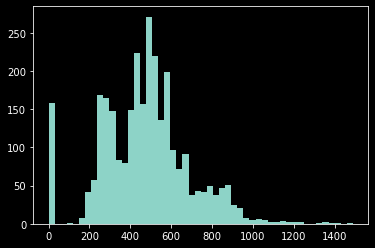

In [27]:
aaa = cols_type['float64'][10]
print(aaa)
plt.hist(df[aaa], bins=50)
plt.show()

<AxesSubplot:>

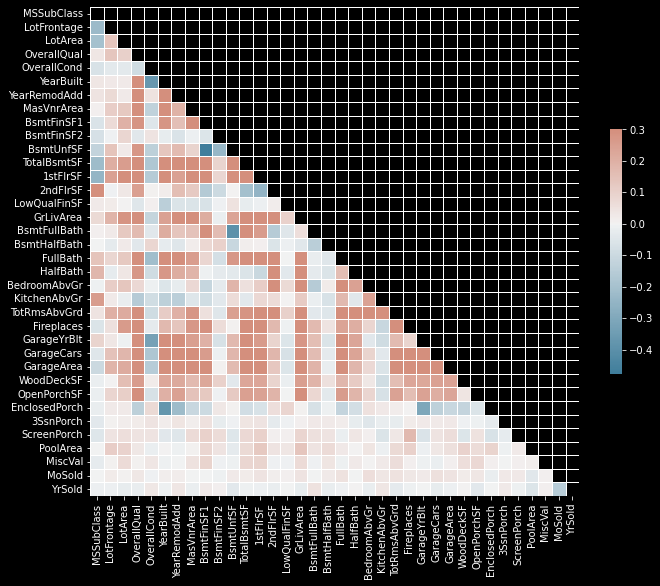

In [28]:
corr = df.drop('Id', axis=1).corr(numeric_only = True)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### Feature Engineering - Creating New Features from Existing Features

In [29]:
df["NewGarage_Flag"] = np.where(df["YearBuilt"] < df["GarageYrBlt"], 1, 0)
df["GarageDelta"] =  df["GarageYrBlt"] - df["YearBuilt"]

In [30]:
df.loc[df["GarageDelta"] < 0, "GarageYrBlt"] = df["YearBuilt"]
df["GarageDelta"] =  df["GarageYrBlt"] - df["YearBuilt"]
df["GarageDelta"] = df["GarageDelta"].fillna(0)

In [31]:
df["BuiltPeriod"] = pd.cut(df["YearBuilt"], [-99999, 1919, 1939, 1949, 1959, 1969, 1979, 1989, 1999, 99999],
                          labels = ["Pre 1920", "1920 - 1939", "1940 - 1949", "1950 - 1959", "1960 - 1969",
                                    "1970 - 1979", "1980 - 1989", "1990 - 1999", "2000 - 2010"]
                          )

In [32]:
df["Remod_Flag"] = np.where(df["YearBuilt"] == df["YearRemodAdd"], 0, 1)
df["RemodDelta"] =  df["YearRemodAdd"] - df["YearBuilt"]
df.loc[df["RemodDelta"] < 0, "YearRemodAdd"] = df["YearBuilt"]
df["GarageDelta"] =  df["GarageYrBlt"] - df["YearBuilt"]
df["GarageDelta"] = df["GarageDelta"].fillna(0)

In [33]:
df = df.drop("GarageYrBlt", axis=1)

### Data Preparation - Standardisation, Encoding, Column Dropping, Train/Test Split

In [56]:
OH_targs = ["MSSubClass", "MSZoning", "Street", "Alley", "LotShape", "LandContour", "LotConfig",
            "LandSlope", "Neighborhood", "Condition1", "Condition2", "BldgType", "HouseStyle",
            "BuiltPeriod", "RoofStyle", "RoofMatl", "Exterior1st", "Exterior2nd", "MasVnrType",
            "Heating", "CentralAir", "Electrical", "BsmtFullBath", "BsmtHalfBath", "FullBath",
            "HalfBath", "BedroomAbvGr", "KitchenAbvGr", "TotRmsAbvGrd", "Fireplaces", "GarageType",
            "GarageFinish", "GarageCars", "PavedDrive", "Foundation", "MiscFeature", "MoSold",
            "YrSold", "SaleType", "SaleCondition"]
std_targs = ["LotFrontage", "LotArea", "RemodDelta", "GarageDelta",
             "MasVnrArea", "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF",
             "1stFlrSF", "2ndFlrSF", "LowQualFinSF", "GrLivArea", "GarageArea", "WoodDeckSF",
             "OpenPorchSF", "EnclosedPorch", "3SsnPorch", "ScreenPorch", "PoolArea", "MiscVal"]
ready_flags = ["Remod_Flag", "NewGarage_Flag", "OverallQual", "OverallCond"]
heirarchy_num_targs = ["ExterQual", "ExterCond", "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1",
                      "BsmtFinType2", "HeatingQC", "KitchenQual", "Functional", "FireplaceQu", "GarageQual",
                       "GarageCond", "PoolQC", "Fence"]
requirements = ["Id", "SetIdentifier"]

In [79]:
def category_change(name):
    df[name] = df[name].astype('category')

In [84]:
for i in OH_targs, ready_flags:
    category_change(i)

In [86]:
big_df = df[[i for i in df.columns if i in OH_targs + std_targs + ready_flags + heirarchy_num_targs + requirements]]

In [87]:
for i in OH_targs:
    enc = pd.get_dummies(big_df[i], prefix=i)
    big_df = pd.concat([big_df, enc], axis=1)

In [88]:
big_df[std_targs] = pd.DataFrame(StandardScaler().fit_transform(big_df[std_targs]))

In [89]:
y_train

0       208500
1       181500
2       223500
3       140000
4       250000
         ...  
1455    175000
1456    210000
1457    266500
1458    142125
1459    147500
Name: SalePrice, Length: 1460, dtype: int64

In [102]:
X_train = big_df[std_targs+OH_targs+ready_flags][big_df["SetIdentifier"]=="Train"]
X_test = big_df[std_targs+OH_targs+ready_flags][big_df["SetIdentifier"]=="Test"]

### Initial Modelling

In [112]:
xgb = XGBRegressor(
    tree_method = "hist",
    max_bin = 512,
    max_cat_threshold = 99999,
    enable_categorical = True,
    gamma = 5
)

In [113]:
xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=5, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=512,
             max_cat_threshold=99999, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [114]:
preds = pd.Series(xgb.predict(X_train))

In [115]:
round(r2_score(preds, y_train), 3)

1.0

In [116]:
round(mean_squared_error(preds, y_train, squared=False),2)

793.79

In [117]:
df.shape

(2919, 84)

In [123]:
pred_test = pd.Series(xgb.predict(X_test))

In [121]:
test

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SetIdentifier
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,Test
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,Test
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,Test
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2010,WD,Normal,Test
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,0,NaN,NaN,NaN,0,1,2010,WD,Normal,Test
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,Test
1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml,Test
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml,Test
1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal,Test


In [126]:
sub = pd.DataFrame({"Id": test["Id"],
              "SalePrice": pred_test})

In [129]:
sub.to_csv('sub.csv', index=False)

### Parameter Tuning

In [106]:
pd.concat([preds, y_train], axis=1)

,0,SalePrice
0,207655.484375,208500
1,181247.859375,181500
2,222396.796875,223500
3,140120.375000,140000
4,250684.390625,250000
...,...,...
1455,174506.203125,175000
1456,209921.875000,210000
1457,266601.062500,266500
1458,142261.484375,142125


### Final Modelling

### Solution Writing